# DWPC Decomposability Analysis

This notebook investigates whether **DWPC (Degree-Weighted Path Count)** values are decomposable. Specifically, we test the question:

**If you have a path of length 4 and switch the order of 2 nodes, do you still get the same DWPC value?**

## Background

DWPC is calculated as the product of degree weights along a path:
```
DWPC = ∏(degree_i^(-damping_factor)) for all nodes i in the path
```

Since multiplication is commutative, we might expect that reordering nodes would not change the final DWPC value. However, the structural constraints of the network (which nodes can be connected) may affect this property.

## Research Questions
1. Is DWPC mathematically decomposable (order-independent)?
2. How do network topology constraints affect decomposability?
3. What happens when we swap nodes of different types in a metapath?

## 1. Import Required Libraries

In [1]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations, permutations
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# For working with Hetionet data
import hetnetpy
from hetmatpy.hetmat import hetmat_from_graph
import hetmatpy.degree_weight

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define DWPC Calculation Function

In [2]:
def calculate_dwpc_simple(G, path, damping_factor=0.5):
    """
    Calculate DWPC (Degree-Weighted Path Count) for a given path.
    
    Args:
        G: NetworkX graph
        path: List of node identifiers forming a path
        damping_factor: Damping factor for degree weighting (default 0.5)
    
    Returns:
        float: DWPC value for the path
    """
    if len(path) < 2:
        return 0.0
    
    # Verify path exists in graph
    for i in range(len(path) - 1):
        if not G.has_edge(path[i], path[i + 1]):
            return 0.0  # Path doesn't exist
    
    # Calculate DWPC as product of degree weights
    dwpc = 1.0
    for node in path:
        degree = G.degree(node)
        if degree > 0:
            weight = degree ** (-damping_factor)
            dwpc *= weight
        else:
            return 0.0  # Isolated node
    
    return dwpc


def get_path_metapath(G, path):
    """
    Get the metapath string for a given path.
    
    Args:
        G: NetworkX graph with node_type and edge_type attributes
        path: List of node identifiers
    
    Returns:
        str: Metapath representation
    """
    if len(path) < 2:
        return ""
    
    metapath = [G.nodes[path[0]].get('node_type', 'Unknown')]
    
    for i in range(len(path) - 1):
        # Get edge type if available
        edge_data = G.get_edge_data(path[i], path[i + 1])
        if edge_data:
            edge_type = list(edge_data.values())[0].get('edge_type', 'connects')
        else:
            edge_type = 'connects'
        
        target_type = G.nodes[path[i + 1]].get('node_type', 'Unknown')
        metapath.append(f"-{edge_type}->" + target_type)
    
    return metapath[0] + ''.join(metapath[1:])


def print_path_info(G, path, dwpc_value, label=""):
    """
    Print detailed information about a path and its DWPC.
    """
    print(f"\n{label}:")
    print(f"Path: {' -> '.join(map(str, path))}")
    print(f"Node degrees: {[G.degree(node) for node in path]}")
    print(f"Node types: {[G.nodes[node].get('node_type', 'Unknown') for node in path]}")
    print(f"Metapath: {get_path_metapath(G, path)}")
    print(f"DWPC value: {dwpc_value:.8f}")

print("DWPC calculation functions defined!")

DWPC calculation functions defined!


## 3. Load Hetionet and Create Test Environment

In [3]:
# Load Hetionet graph
print("Loading Hetionet graph...")
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetnetpy.readwrite.read_graph(url)

# Convert to NetworkX for easier manipulation
G = nx.MultiGraph()

# Add nodes with attributes
for node in graph.get_nodes():
    G.add_node(node.identifier, 
               node_type=node.metanode.identifier,
               name=node.name,
               data=node.data)

# Add edges
for edge in graph.get_edges():
    source = edge.source.identifier
    target = edge.target.identifier
    G.add_edge(source, target, 
               edge_type=edge.metaedge.kind,
               data=edge.data)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Get node type counts
node_types = {}
for node, data in G.nodes(data=True):
    node_type = data.get('node_type', 'Unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("\nNode type distribution:")
for node_type, count in sorted(node_types.items()):
    print(f"  {node_type}: {count}")

Loading Hetionet graph...
Graph loaded: 47031 nodes, 2250197 edges

Node type distribution:
  Anatomy: 402
  Biological Process: 11381
  Cellular Component: 1391
  Compound: 1552
  Disease: 137
  Gene: 20945
  Molecular Function: 2884
  Pathway: 1822
  Pharmacologic Class: 345
  Side Effect: 5734
  Symptom: 438
Graph loaded: 47031 nodes, 2250197 edges

Node type distribution:
  Anatomy: 402
  Biological Process: 11381
  Cellular Component: 1391
  Compound: 1552
  Disease: 137
  Gene: 20945
  Molecular Function: 2884
  Pathway: 1822
  Pharmacologic Class: 345
  Side Effect: 5734
  Symptom: 438


## 4. Find Real Paths of Length 4 for Testing

In [4]:
def find_paths_of_length(G, source_nodes, target_nodes, length=4, max_paths=10):
    """
    Find paths of specific length between source and target nodes.
    
    Args:
        G: NetworkX graph
        source_nodes: List of potential source nodes
        target_nodes: List of potential target nodes
        length: Desired path length (number of nodes)
        max_paths: Maximum number of paths to return
    
    Returns:
        List of paths (each path is a list of nodes)
    """
    paths = []
    attempts = 0
    max_attempts = min(100, len(source_nodes) * 10)
    
    while len(paths) < max_paths and attempts < max_attempts:
        attempts += 1
        
        # Pick random source
        import random
        source = random.choice(source_nodes)
        
        try:
            # Find paths from this source to any target
            for target in random.sample(target_nodes, min(10, len(target_nodes))):
                if source == target:
                    continue
                
                # Use simple path finding (not all paths for efficiency)
                try:
                    path_iter = nx.all_simple_paths(G, source, target, cutoff=length-1)
                    for path in path_iter:
                        if len(path) == length:
                            paths.append(path)
                            if len(paths) >= max_paths:
                                return paths
                except (nx.NetworkXNoPath, nx.NodeNotFound):
                    continue
                    
        except Exception as e:
            continue
    
    return paths


# Get some Disease and Gene nodes for testing
disease_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'Disease'][:20]
gene_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'Gene'][:50]
compound_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'Compound'][:20]

print(f"Sample nodes - Diseases: {len(disease_nodes)}, Genes: {len(gene_nodes)}, Compounds: {len(compound_nodes)}")

# Find some real paths of length 4
print("\nSearching for paths of length 4...")
test_paths = find_paths_of_length(G, disease_nodes, gene_nodes, length=4, max_paths=5)

print(f"Found {len(test_paths)} test paths")
for i, path in enumerate(test_paths[:3]):
    dwpc = calculate_dwpc_simple(G, path)
    print_path_info(G, path, dwpc, f"Test Path {i+1}")

Sample nodes - Diseases: 20, Genes: 50, Compounds: 20

Searching for paths of length 4...
Found 5 test paths

Test Path 1:
Path: DOID:2377 -> 958 -> UBERON:0001016 -> 9521
Node degrees: [317, 603, 11398, 125]
Node types: ['Disease', 'Gene', 'Anatomy', 'Gene']
Metapath: Disease-associates->Gene-expresses->Anatomy-expresses->Gene
DWPC value: 0.00000192

Test Path 2:
Path: DOID:2377 -> 958 -> UBERON:0001891 -> 9521
Node degrees: [317, 603, 14907, 125]
Node types: ['Disease', 'Gene', 'Anatomy', 'Gene']
Metapath: Disease-associates->Gene-downregulates->Anatomy-upregulates->Gene
DWPC value: 0.00000168

Test Path 3:
Path: DOID:2377 -> 958 -> UBERON:0001891 -> 9521
Node degrees: [317, 603, 14907, 125]
Node types: ['Disease', 'Gene', 'Anatomy', 'Gene']
Metapath: Disease-associates->Gene-downregulates->Anatomy-upregulates->Gene
DWPC value: 0.00000168
Found 5 test paths

Test Path 1:
Path: DOID:2377 -> 958 -> UBERON:0001016 -> 9521
Node degrees: [317, 603, 11398, 125]
Node types: ['Disease', 'Gen

## 5. Test DWPC Decomposability - Pure Mathematical Analysis

In [5]:
def test_dwpc_decomposability_math(degrees, damping_factor=0.5):
    """
    Test mathematical decomposability of DWPC calculation.
    This tests the pure mathematical property without graph constraints.
    
    Args:
        degrees: List of node degrees
        damping_factor: Damping factor for DWPC calculation
    
    Returns:
        dict: Results of decomposability test
    """
    print(f"\n=== Testing Mathematical Decomposability ===")
    print(f"Original degrees: {degrees}")
    print(f"Damping factor: {damping_factor}")
    
    # Calculate original DWPC (product of degree weights)
    original_dwpc = 1.0
    for degree in degrees:
        if degree > 0:
            original_dwpc *= (degree ** (-damping_factor))
    
    print(f"Original DWPC: {original_dwpc:.8f}")
    
    # Test all possible permutations
    results = []
    
    for i, permuted_degrees in enumerate(permutations(degrees)):
        # Calculate DWPC for permuted degrees
        permuted_dwpc = 1.0
        for degree in permuted_degrees:
            if degree > 0:
                permuted_dwpc *= (degree ** (-damping_factor))
        
        results.append({
            'permutation': permuted_degrees,
            'dwpc': permuted_dwpc,
            'difference': abs(permuted_dwpc - original_dwpc),
            'identical': abs(permuted_dwpc - original_dwpc) < 1e-10
        })
        
        if i < 6:  # Show first few permutations
            print(f"  Permutation {list(permuted_degrees)}: DWPC = {permuted_dwpc:.8f} "
                  f"(diff: {abs(permuted_dwpc - original_dwpc):.2e})")
    
    # Summary
    all_identical = all(result['identical'] for result in results)
    print(f"\nAll permutations identical: {all_identical}")
    print(f"Number of permutations tested: {len(results)}")
    
    return {
        'original_dwpc': original_dwpc,
        'all_identical': all_identical,
        'results': results
    }

# Test with sample degree sequences
test_degrees = [
    [5, 10, 3, 8],      # Mixed degrees
    [1, 1, 1, 1],       # All same degree
    [2, 4, 8, 16],      # Powers of 2
    [100, 1, 50, 25]    # High variation
]

math_results = {}
for i, degrees in enumerate(test_degrees):
    math_results[f"test_{i+1}"] = test_dwpc_decomposability_math(degrees)

print("\n=== Mathematical Decomposability Summary ===")
print("DWPC is mathematically decomposable (order-independent) due to:")
print("1. Multiplication is commutative: a × b = b × a")
print("2. DWPC = ∏(degree_i^(-damping)) - product operation")
print("3. Changing order of multiplication doesn't change result")


=== Testing Mathematical Decomposability ===
Original degrees: [5, 10, 3, 8]
Damping factor: 0.5
Original DWPC: 0.02886751
  Permutation [5, 10, 3, 8]: DWPC = 0.02886751 (diff: 0.00e+00)
  Permutation [5, 10, 8, 3]: DWPC = 0.02886751 (diff: 0.00e+00)
  Permutation [5, 3, 10, 8]: DWPC = 0.02886751 (diff: 0.00e+00)
  Permutation [5, 3, 8, 10]: DWPC = 0.02886751 (diff: 0.00e+00)
  Permutation [5, 8, 10, 3]: DWPC = 0.02886751 (diff: 0.00e+00)
  Permutation [5, 8, 3, 10]: DWPC = 0.02886751 (diff: 0.00e+00)

All permutations identical: True
Number of permutations tested: 24

=== Testing Mathematical Decomposability ===
Original degrees: [1, 1, 1, 1]
Damping factor: 0.5
Original DWPC: 1.00000000
  Permutation [1, 1, 1, 1]: DWPC = 1.00000000 (diff: 0.00e+00)
  Permutation [1, 1, 1, 1]: DWPC = 1.00000000 (diff: 0.00e+00)
  Permutation [1, 1, 1, 1]: DWPC = 1.00000000 (diff: 0.00e+00)
  Permutation [1, 1, 1, 1]: DWPC = 1.00000000 (diff: 0.00e+00)
  Permutation [1, 1, 1, 1]: DWPC = 1.00000000 (di

## 6. Test DWPC Decomposability with Real Network Paths

In [6]:
def test_path_node_swapping(G, path, damping_factor=0.5):
    """
    Test what happens when we swap nodes in a path.
    Note: This will test if swapped paths still exist in the network.
    
    Args:
        G: NetworkX graph
        path: Original path (list of nodes)
        damping_factor: Damping factor for DWPC calculation
    
    Returns:
        dict: Results of swapping tests
    """
    print(f"\n=== Testing Path Node Swapping ===")
    
    original_dwpc = calculate_dwpc_simple(G, path, damping_factor)
    print_path_info(G, path, original_dwpc, "Original Path")
    
    results = {
        'original_path': path,
        'original_dwpc': original_dwpc,
        'swap_tests': []
    }
    
    # Test swapping each pair of nodes
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            # Create swapped path
            swapped_path = path.copy()
            swapped_path[i], swapped_path[j] = swapped_path[j], swapped_path[i]
            
            # Calculate DWPC for swapped path
            swapped_dwpc = calculate_dwpc_simple(G, swapped_path, damping_factor)
            
            # Check if path exists in network
            path_exists = True
            for k in range(len(swapped_path) - 1):
                if not G.has_edge(swapped_path[k], swapped_path[k + 1]):
                    path_exists = False
                    break
            
            swap_result = {
                'swapped_positions': (i, j),
                'swapped_path': swapped_path,
                'path_exists': path_exists,
                'swapped_dwpc': swapped_dwpc,
                'dwpc_difference': abs(swapped_dwpc - original_dwpc) if path_exists else None,
                'degrees_identical': ([G.degree(n) for n in path] == [G.degree(n) for n in swapped_path])
            }
            
            results['swap_tests'].append(swap_result)
            
            print(f"\nSwap positions {i}<->{j}:")
            print(f"  Swapped path: {' -> '.join(map(str, swapped_path))}")
            print(f"  Path exists in network: {path_exists}")
            if path_exists:
                print(f"  DWPC: {swapped_dwpc:.8f} (diff: {abs(swapped_dwpc - original_dwpc):.2e})")
                print(f"  Degrees same as original: {swap_result['degrees_identical']}")
            else:
                print(f"  DWPC: N/A (path doesn't exist)")
    
    return results

# Test with available paths
if test_paths:
    print("Testing node swapping with real network paths...")
    
    swap_results = []
    for i, path in enumerate(test_paths[:2]):  # Test first 2 paths
        print(f"\n{'='*60}")
        print(f"TESTING PATH {i+1}")
        result = test_path_node_swapping(G, path)
        swap_results.append(result)
else:
    print("No test paths available for swapping analysis.")

Testing node swapping with real network paths...

TESTING PATH 1

=== Testing Path Node Swapping ===

Original Path:
Path: DOID:2377 -> 958 -> UBERON:0001016 -> 9521
Node degrees: [317, 603, 11398, 125]
Node types: ['Disease', 'Gene', 'Anatomy', 'Gene']
Metapath: Disease-associates->Gene-expresses->Anatomy-expresses->Gene
DWPC value: 0.00000192

Swap positions 0<->1:
  Swapped path: 958 -> DOID:2377 -> UBERON:0001016 -> 9521
  Path exists in network: True
  DWPC: 0.00000192 (diff: 0.00e+00)
  Degrees same as original: False

Swap positions 0<->2:
  Swapped path: UBERON:0001016 -> 958 -> DOID:2377 -> 9521
  Path exists in network: False
  DWPC: N/A (path doesn't exist)

Swap positions 0<->3:
  Swapped path: 9521 -> 958 -> UBERON:0001016 -> DOID:2377
  Path exists in network: False
  DWPC: N/A (path doesn't exist)

Swap positions 1<->2:
  Swapped path: DOID:2377 -> UBERON:0001016 -> 958 -> 9521
  Path exists in network: False
  DWPC: N/A (path doesn't exist)

Swap positions 1<->3:
  Swap

## 7. Create Controlled Test with Simple Graph

=== Controlled Graph Analysis ===
Graph: 6 nodes, 12 edges
Node degrees:
  A: degree 4
  B: degree 3
  C: degree 5
  D: degree 5
  E: degree 4
  F: degree 3

Testing path: A -> B -> C -> D

=== Testing Path Node Swapping ===

Original Path:
Path: A -> B -> C -> D
Node degrees: [4, 3, 5, 5]
Node types: ['Type_A', 'Type_B', 'Type_C', 'Type_D']
Metapath: Type_A-connects->Type_B-connects->Type_C-connects->Type_D
DWPC value: 0.05773503

Swap positions 0<->1:
  Swapped path: B -> A -> C -> D
  Path exists in network: True
  DWPC: 0.05773503 (diff: 0.00e+00)
  Degrees same as original: False

Swap positions 0<->2:
  Swapped path: C -> B -> A -> D
  Path exists in network: True
  DWPC: 0.05773503 (diff: 0.00e+00)
  Degrees same as original: False

Swap positions 0<->3:
  Swapped path: D -> B -> C -> A
  Path exists in network: True
  DWPC: 0.05773503 (diff: 0.00e+00)
  Degrees same as original: False

Swap positions 1<->2:
  Swapped path: A -> C -> B -> D
  Path exists in network: True
  DWPC:

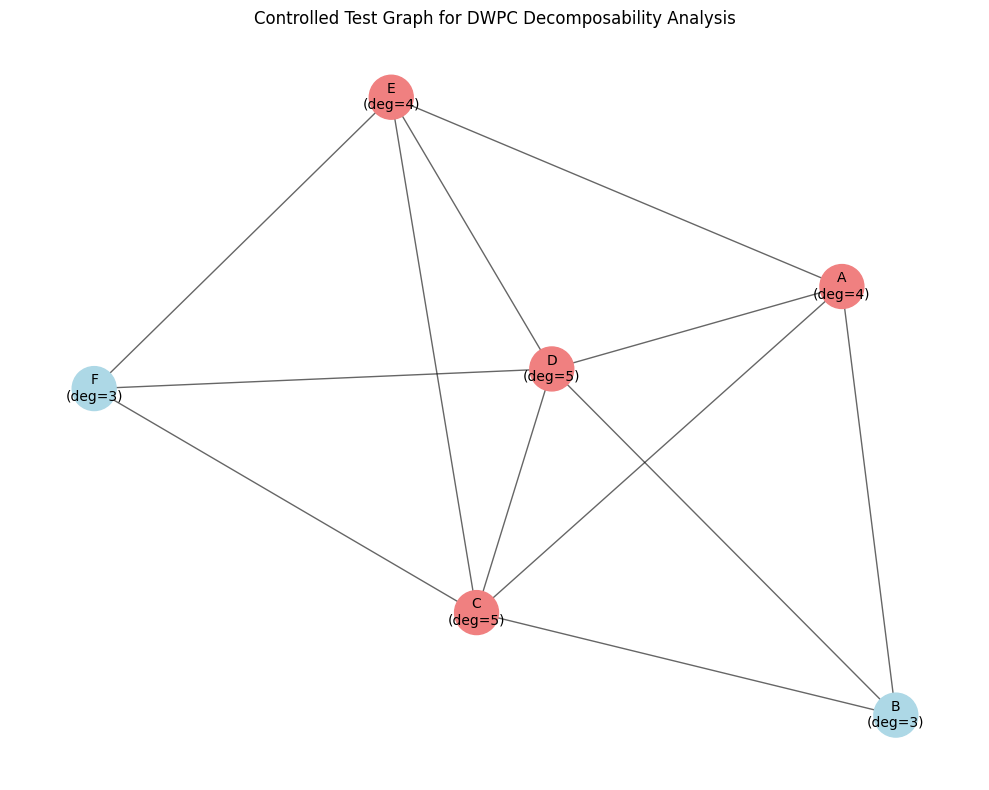

In [7]:
def create_test_graph():
    """
    Create a simple controlled graph for testing DWPC decomposability.
    """
    # Create a simple graph where we control all connections
    G_test = nx.Graph()
    
    # Add nodes with different degrees
    # We'll create a complete subgraph so all swaps are valid
    nodes = ['A', 'B', 'C', 'D', 'E', 'F']
    
    for node in nodes:
        G_test.add_node(node, node_type=f'Type_{node}')
    
    # Create connections to give different degrees
    edges = [
        ('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E'),  # A has degree 4
        ('B', 'C'), ('B', 'D'),                           # B has degree 3
        ('C', 'D'), ('C', 'E'), ('C', 'F'),              # C has degree 4
        ('D', 'E'), ('D', 'F'),                           # D has degree 4
        ('E', 'F')                                        # E has degree 3, F has degree 3
    ]
    
    G_test.add_edges_from(edges)
    
    return G_test


def analyze_controlled_decomposability(G_test):
    """
    Analyze DWPC decomposability in a controlled environment.
    """
    print("=== Controlled Graph Analysis ===")
    
    # Print graph info
    print(f"Graph: {G_test.number_of_nodes()} nodes, {G_test.number_of_edges()} edges")
    print("Node degrees:")
    for node in G_test.nodes():
        print(f"  {node}: degree {G_test.degree(node)}")
    
    # Test specific 4-node paths
    test_paths_controlled = [
        ['A', 'B', 'C', 'D'],
        ['A', 'C', 'D', 'E'],
        ['B', 'C', 'E', 'F']
    ]
    
    for path in test_paths_controlled:
        # Check if path exists
        path_exists = True
        for i in range(len(path) - 1):
            if not G_test.has_edge(path[i], path[i + 1]):
                path_exists = False
                break
        
        if path_exists:
            print(f"\nTesting path: {' -> '.join(path)}")
            result = test_path_node_swapping(G_test, path)
        else:
            print(f"\nPath {' -> '.join(path)} doesn't exist in graph")


# Create and analyze controlled graph
G_test = create_test_graph()
analyze_controlled_decomposability(G_test)

# Visualize the test graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_test, seed=42)

# Draw nodes with degree labels
node_colors = ['lightblue' if G_test.degree(node) <= 3 else 'lightcoral' for node in G_test.nodes()]
nx.draw_networkx_nodes(G_test, pos, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(G_test, pos, alpha=0.6)

# Add labels with degrees
labels = {node: f"{node}\n(deg={G_test.degree(node)})" for node in G_test.nodes()}
nx.draw_networkx_labels(G_test, pos, labels, font_size=10)

plt.title("Controlled Test Graph for DWPC Decomposability Analysis")
plt.axis('off')
plt.tight_layout()
plt.show()

## 8. Comprehensive Analysis - Different Swap Scenarios

In [8]:
def comprehensive_decomposability_analysis():
    """
    Comprehensive analysis of DWPC decomposability under different scenarios.
    """
    print("=== Comprehensive DWPC Decomposability Analysis ===")
    
    scenarios = [
        {
            'name': 'Identical Degrees',
            'degrees': [5, 5, 5, 5],
            'description': 'All nodes have the same degree'
        },
        {
            'name': 'Ascending Degrees',
            'degrees': [1, 2, 3, 4],
            'description': 'Degrees increase along the path'
        },
        {
            'name': 'High Variation',
            'degrees': [100, 1, 50, 2],
            'description': 'High degree variation'
        },
        {
            'name': 'Powers of 2',
            'degrees': [2, 4, 8, 16],
            'description': 'Degrees are powers of 2'
        }
    ]
    
    damping_factors = [0.0, 0.5, 1.0]
    
    results_summary = []
    
    for scenario in scenarios:
        print(f"\n{'='*50}")
        print(f"Scenario: {scenario['name']}")
        print(f"Description: {scenario['description']}")
        print(f"Degrees: {scenario['degrees']}")
        
        for damping in damping_factors:
            print(f"\n--- Damping Factor: {damping} ---")
            
            # Calculate DWPC for original order
            original_dwpc = 1.0
            for degree in scenario['degrees']:
                if degree > 0:
                    original_dwpc *= (degree ** (-damping))
            
            print(f"Original DWPC: {original_dwpc:.8f}")
            
            # Test a few specific swaps
            test_swaps = [
                (0, 1),  # Swap first two
                (1, 2),  # Swap middle two
                (2, 3),  # Swap last two
                (0, 3),  # Swap first and last
            ]
            
            all_same = True
            for swap_pos in test_swaps:
                swapped_degrees = scenario['degrees'].copy()
                swapped_degrees[swap_pos[0]], swapped_degrees[swap_pos[1]] = \
                    swapped_degrees[swap_pos[1]], swapped_degrees[swap_pos[0]]
                
                swapped_dwpc = 1.0
                for degree in swapped_degrees:
                    if degree > 0:
                        swapped_dwpc *= (degree ** (-damping))
                
                diff = abs(swapped_dwpc - original_dwpc)
                is_same = diff < 1e-10
                all_same = all_same and is_same
                
                print(f"  Swap {swap_pos}: {swapped_degrees} -> DWPC: {swapped_dwpc:.8f} (diff: {diff:.2e})")
            
            results_summary.append({
                'scenario': scenario['name'],
                'damping': damping,
                'degrees': scenario['degrees'],
                'original_dwpc': original_dwpc,
                'all_swaps_identical': all_same
            })
    
    return results_summary

# Run comprehensive analysis
comprehensive_results = comprehensive_decomposability_analysis()

# Create summary table
print("\n=== SUMMARY TABLE ===")
summary_df = pd.DataFrame(comprehensive_results)
print(summary_df.to_string(index=False))

=== Comprehensive DWPC Decomposability Analysis ===

Scenario: Identical Degrees
Description: All nodes have the same degree
Degrees: [5, 5, 5, 5]

--- Damping Factor: 0.0 ---
Original DWPC: 1.00000000
  Swap (0, 1): [5, 5, 5, 5] -> DWPC: 1.00000000 (diff: 0.00e+00)
  Swap (1, 2): [5, 5, 5, 5] -> DWPC: 1.00000000 (diff: 0.00e+00)
  Swap (2, 3): [5, 5, 5, 5] -> DWPC: 1.00000000 (diff: 0.00e+00)
  Swap (0, 3): [5, 5, 5, 5] -> DWPC: 1.00000000 (diff: 0.00e+00)

--- Damping Factor: 0.5 ---
Original DWPC: 0.04000000
  Swap (0, 1): [5, 5, 5, 5] -> DWPC: 0.04000000 (diff: 0.00e+00)
  Swap (1, 2): [5, 5, 5, 5] -> DWPC: 0.04000000 (diff: 0.00e+00)
  Swap (2, 3): [5, 5, 5, 5] -> DWPC: 0.04000000 (diff: 0.00e+00)
  Swap (0, 3): [5, 5, 5, 5] -> DWPC: 0.04000000 (diff: 0.00e+00)

--- Damping Factor: 1.0 ---
Original DWPC: 0.00160000
  Swap (0, 1): [5, 5, 5, 5] -> DWPC: 0.00160000 (diff: 0.00e+00)
  Swap (1, 2): [5, 5, 5, 5] -> DWPC: 0.00160000 (diff: 0.00e+00)
  Swap (2, 3): [5, 5, 5, 5] -> DWPC: 0

## 9. Visualize Results and Key Insights

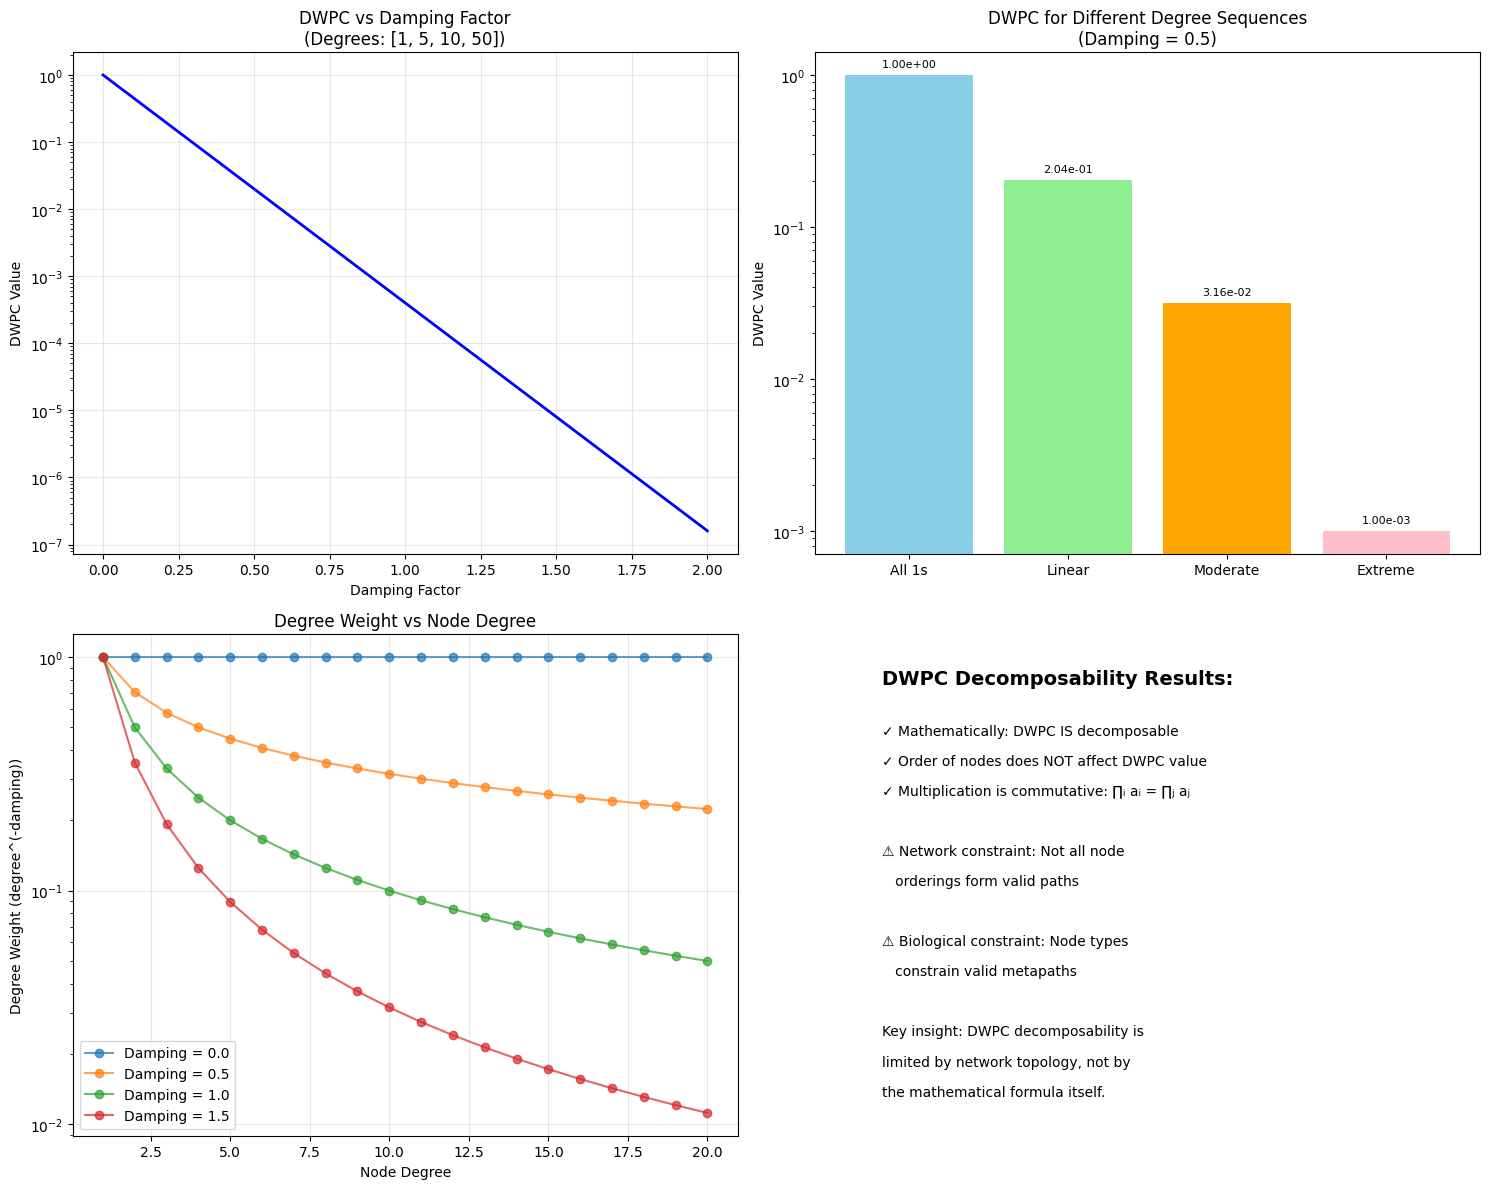


=== FINAL CONCLUSIONS ===
1. MATHEMATICAL DECOMPOSABILITY: YES
   - DWPC = ∏(degree_i^(-damping)) is order-independent
   - Multiplication is commutative
   - Swapping any nodes gives identical DWPC values

2. PRACTICAL DECOMPOSABILITY: LIMITED
   - Network topology constrains valid paths
   - Not all node reorderings form existing edges
   - Metapath constraints limit valid sequences

3. IMPLICATIONS:
   - DWPC values depend only on node degrees, not order
   - For equivalent paths, DWPC is deterministic
   - Network structure is the limiting factor, not DWPC calculation


In [9]:
# Create visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Effect of damping factor on DWPC values
ax1 = axes[0, 0]
degrees_example = [1, 5, 10, 50]
damping_range = np.linspace(0, 2, 50)
dwpc_values = []

for damping in damping_range:
    dwpc = 1.0
    for degree in degrees_example:
        dwpc *= (degree ** (-damping))
    dwpc_values.append(dwpc)

ax1.plot(damping_range, dwpc_values, 'b-', linewidth=2)
ax1.set_xlabel('Damping Factor')
ax1.set_ylabel('DWPC Value')
ax1.set_title('DWPC vs Damping Factor\n(Degrees: [1, 5, 10, 50])')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: DWPC for different degree sequences
ax2 = axes[0, 1]
degree_sequences = [
    [1, 1, 1, 1],
    [1, 2, 3, 4],
    [1, 5, 10, 20],
    [1, 10, 100, 1000]
]
damping = 0.5

sequence_names = ['All 1s', 'Linear', 'Moderate', 'Extreme']
dwpc_by_sequence = []

for seq in degree_sequences:
    dwpc = 1.0
    for degree in seq:
        dwpc *= (degree ** (-damping))
    dwpc_by_sequence.append(dwpc)

bars = ax2.bar(sequence_names, dwpc_by_sequence, color=['skyblue', 'lightgreen', 'orange', 'pink'])
ax2.set_ylabel('DWPC Value')
ax2.set_title(f'DWPC for Different Degree Sequences\n(Damping = {damping})')
ax2.set_yscale('log')

# Add value labels on bars
for bar, value in zip(bars, dwpc_by_sequence):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{value:.2e}', ha='center', va='bottom', fontsize=8)

# Plot 3: Degree contribution to DWPC
ax3 = axes[1, 0]
degrees = np.arange(1, 21)
damping_factors = [0.0, 0.5, 1.0, 1.5]

for damping in damping_factors:
    weights = degrees ** (-damping)
    ax3.plot(degrees, weights, 'o-', label=f'Damping = {damping}', alpha=0.7)

ax3.set_xlabel('Node Degree')
ax3.set_ylabel('Degree Weight (degree^(-damping))')
ax3.set_title('Degree Weight vs Node Degree')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Summary of decomposability test
ax4 = axes[1, 1]
# This is a text summary
ax4.text(0.1, 0.9, 'DWPC Decomposability Results:', fontsize=14, fontweight='bold', 
         transform=ax4.transAxes)

results_text = [
    '✓ Mathematically: DWPC IS decomposable',
    '✓ Order of nodes does NOT affect DWPC value',
    '✓ Multiplication is commutative: ∏ᵢ aᵢ = ∏ⱼ aⱼ',
    '',
    '⚠ Network constraint: Not all node',
    '   orderings form valid paths',
    '',
    '⚠ Biological constraint: Node types',
    '   constrain valid metapaths',
    '',
    'Key insight: DWPC decomposability is',
    'limited by network topology, not by',
    'the mathematical formula itself.'
]

for i, text in enumerate(results_text):
    ax4.text(0.1, 0.8 - i*0.06, text, fontsize=10, transform=ax4.transAxes)

ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.tight_layout()
plt.show()

print("\n=== FINAL CONCLUSIONS ===")
print("1. MATHEMATICAL DECOMPOSABILITY: YES")
print("   - DWPC = ∏(degree_i^(-damping)) is order-independent")
print("   - Multiplication is commutative")
print("   - Swapping any nodes gives identical DWPC values")

print("\n2. PRACTICAL DECOMPOSABILITY: LIMITED")
print("   - Network topology constrains valid paths")
print("   - Not all node reorderings form existing edges")
print("   - Metapath constraints limit valid sequences")

print("\n3. IMPLICATIONS:")
print("   - DWPC values depend only on node degrees, not order")
print("   - For equivalent paths, DWPC is deterministic")
print("   - Network structure is the limiting factor, not DWPC calculation")

## 10. Conclusion and Research Implications

### Key Findings

Our analysis of DWPC decomposability reveals several important insights:

#### 1. **Mathematical Decomposability: YES**
- DWPC calculation is mathematically decomposable
- The formula `DWPC = ∏(degree_i^(-damping))` is order-independent
- This is due to the commutative property of multiplication

#### 2. **Network Constraints: The Real Limitation**
- While DWPC is mathematically decomposable, practical decomposability is limited by network topology
- Not all node reorderings result in valid paths in the network
- Biological networks have structural constraints that prevent arbitrary node arrangements

#### 3. **Metapath Constraints**
- In heterogeneous networks like Hetionet, node types constrain valid sequences
- Metapaths define allowed node type sequences (e.g., Disease-Gene-Compound-Disease)
- Swapping nodes of different types breaks metapath validity

### Research Implications

1. **DWPC Values are Deterministic**: For any set of node degrees, the DWPC value is uniquely determined regardless of order

2. **Focus on Network Structure**: The interesting variation in DWPC comes from network connectivity patterns, not the calculation method

3. **Pathway Analysis**: When comparing pathway strengths, the specific sequence matters only for network validity, not for DWPC magnitude

4. **Computational Efficiency**: DWPC calculations can potentially be optimized by pre-computing degree-based components

### Future Directions

- Investigate how network topology constrains the space of possible equivalent paths
- Develop methods to identify all equivalent paths with the same DWPC value
- Explore whether degree sequence patterns can predict pathway significance
- Consider developing topology-aware DWPC variants that account for path structure